# 4/23: Plate 2

Gates tentatively determined relative to shapes and percentages outlined in Farhat et al. Figure S3. Here, magnitudes have been transformed by log10, but do not appear consistent with S3.

In [1]:
import os
import string
import numpy as np
import pandas as pd
from FlowCytometryTools import ThresholdGate, PolyGate
from matplotlib import pyplot as plt
from matplotlib import cm
from flow import importF

/usr/local/lib/python3.8/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/usr/local/lib/python3.8/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
path_ = os.path.abspath("")

In [3]:
def compMatrix(date, plate, panel, invert=True):
    """Applies compensation matrix given parameters date in mm-dd, plate number and panel A, B, or C."""
    path = path_ + "/data/compensation/"+date+"/Plate "+plate+"/Plate "+plate+" - "+panel+".csv"
    header_names = ['Channel1', 'Channel2', 'Comp']
    df_comp = pd.read_csv(path, header=None, skiprows=1, names=header_names)
    #Add diangonal values of 100 to compensation values
    addedChannels = []
    for i in df_comp.index:
        channelName = df_comp.iloc[i]['Channel1']
        if channelName not in addedChannels:
            addedChannels.append(channelName)
            df2 = pd.DataFrame([[channelName, channelName, 100]], columns=['Channel1', 'Channel2', 'Comp'])
            df_comp = df_comp.append(df2, ignore_index=True)
    #create square matrix from compensation values
    df_matrix = pd.DataFrame(index=addedChannels, columns=addedChannels)
    for i in df_matrix.index:
        for c in df_matrix.columns:
            df_matrix.at[i, c] = df_comp.loc[(df_comp['Channel1'] == c) & (df_comp['Channel2'] == i), 'Comp'].iloc[0]
            #switch i and c to transpose
    #df_matrix now has all values in square matrix form
    if invert:
        a = np.matrix(df_matrix.values, dtype=float)
        df_matrix = pd.DataFrame(np.linalg.inv(a), df_matrix.columns, df_matrix.index)
    return df_matrix

In [4]:
def applyMatrix(sample, matrix):
    """Multiples two matrices together in the order sample dot matrix"""
    for c in sample.data.columns:
        if c not in matrix:
            sample.data = sample.data.drop([c], axis=1)
    sample.data = sample.data.dot(matrix)
    return sample

In [5]:
def combineWells(samples, channels_):
    """Accepts sample array returned from importF, and array of channels, returns transformed combined well data"""
    combinedSamples = samples[0]
    for sample in samples[1:]:
        combinedSamples.data = combinedSamples.data.append(sample.data)
    return combinedSamples

In [6]:
sample1A, _ = importF(path_ + "/data/PBMC-rec-quant/04-23/Plate 2/Plate 2 - Panel 1 IL2R/", "A")
sample2B, _ = importF(path_ + "/data/PBMC-rec-quant/04-23/Plate 2/Plate 2 - Panel 2 IL2R/", "B")
sample3C, _ = importF(path_ + "/data/PBMC-rec-quant/04-23/Plate 2/Plate 2 - Panel 3 IL2R/", "C")

In [7]:
panel1 = combineWells(sample1A, ['VL6-H', 'VL4-H', 'BL1-H', 'VL1-H', 'BL3-H'])
panel2 = combineWells(sample2B, ['VL4-H', 'BL3-H', 'FSC-H'])
panel3 = combineWells(sample3C, ['VL6-H', 'VL4-H', 'BL3-H'])

panel1 = applyMatrix(panel1, compMatrix('04-23', '2','A'))
panel2 = applyMatrix(panel2, compMatrix('04-23', '2','B'))
panel3 = applyMatrix(panel3, compMatrix('04-23', '2','C'))

panel1 = panel1.transform("tlog", channels=['VL6-H', 'VL4-H', 'BL1-H', 'VL1-H', 'BL3-H'])
panel2 = panel2.transform("tlog", channels=['VL4-H', 'BL3-H'])
panel3 = panel3.transform("tlog", channels=['VL6-H', 'VL4-H', 'BL3-H'])

/usr/local/lib/python3.8/dist-packages/FlowCytometryTools/core/transforms.py:80: RuntimeWarning: invalid value encountered in log10
  return where(x <= th, log10(th) * 1. * r / d, log10(x) * 1. * r / d)


## C) T helper and T regulatory cells

Percent gated as CD3+CD4+:  46.76002685054069 %


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


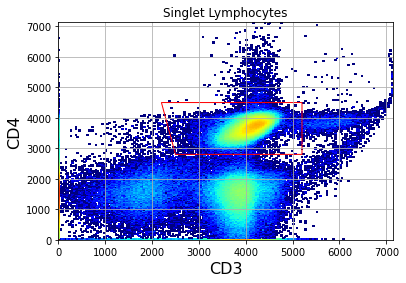

In [8]:
cd3cd4_gate = PolyGate([(2.2e03, 4.5e03), (2.5e03, 2.8e03), (5.2e03, 2.8e03), (5.2e03, 4.5e03)], ('VL4-H', 'VL6-H'), region='in', name='cd3cd4')
_ = panel1.plot(['VL4-H','VL6-H'], gates=cd3cd4_gate, gate_colors=['red'], cmap=cm.jet) #CD3, CD4
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD4")
plt.grid()
print("Percent gated as CD3+CD4+: ", panel1.gate(cd3cd4_gate).counts/panel1.counts*100., "%")

The above shape and percentage are consistent with S3(C).

Percent gated as T helper:  77.2726581007117 %
Percent gated as Treg:  3.4082896665770503 %


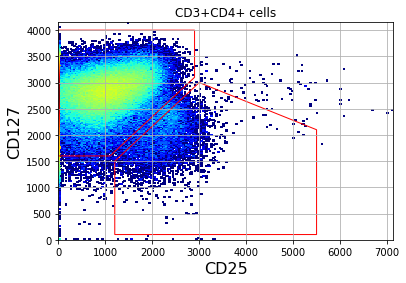

In [9]:
samplecd3cd4 = panel1.gate(cd3cd4_gate)
thelp_gate = PolyGate([(0.00e03, 4e03), (0.00e03, 1.6e03), (1.1e03, 1.6e03), (2.9e03, 3.1e03), (2.9e03, 4e03)], ('VL1-H', 'BL1-H'), region='in', name='thelp')
treg_gate = PolyGate([(1.2e03, 1.5e03), (1.2e03, 0.1e03), (5.5e03, 0.1e03), (5.5e03, 2.1e03), (3.0e03, 3.0e3)], ('VL1-H', 'BL1-H'), region='in', name='treg')
_ = samplecd3cd4.plot(['VL1-H','BL1-H'], gates=[thelp_gate,treg_gate], gate_colors=['red','red'], cmap=cm.jet) #CD3, CD4
plt.title("CD3+CD4+ cells")
plt.xlabel("CD25")
plt.ylabel("CD127")
plt.grid()
print("Percent gated as T helper: ", samplecd3cd4.gate(thelp_gate).counts/samplecd3cd4.counts*100., "%")
print("Percent gated as Treg: ", samplecd3cd4.gate(treg_gate).counts/samplecd3cd4.counts*100., "%")

The above shape is similar to S3(C), but the percentage of Tregs is lower than 6%.

In [10]:
samplethelp = samplecd3cd4.gate(thelp_gate)
sampletreg = samplecd3cd4.gate(treg_gate)

Percent gated as Memory T helper:  32.3324558697065 %
Percent gated as Naive T helper:  55.583491429959366 %


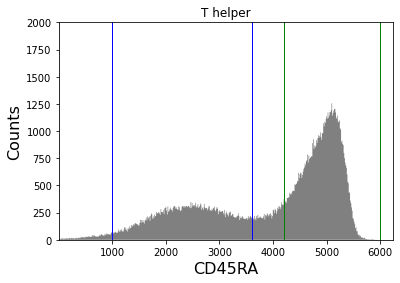

In [11]:
memthelpgate = ThresholdGate(3600.0, ['BL3-H'], region='below') & ThresholdGate(0.0, ['BL3-H'], region='above')
naivethelpgate = ThresholdGate(4200.0, ['BL3-H'], region='above') & ThresholdGate(6000.0, ['BL3-H'], region='below')
_ = samplethelp.plot(['BL3-H'], gates=[memthelpgate,naivethelpgate], bins=500)
plt.xlabel("CD45RA")
plt.title("T helper")
plt.xlim(left=1)
plt.ylim(top=2000)
print("Percent gated as Memory T helper: ", samplethelp.gate(memthelpgate).counts/samplethelp.counts*100., "%")
print("Percent gated as Naive T helper: ", samplethelp.gate(naivethelpgate).counts/samplethelp.counts*100., "%")

The above shape and percentages are consistent with S3(C).

Percent gated as Memory Treg:  60.6786724214913 %
Percent gated as Naive Treg:  25.25673463312993 %


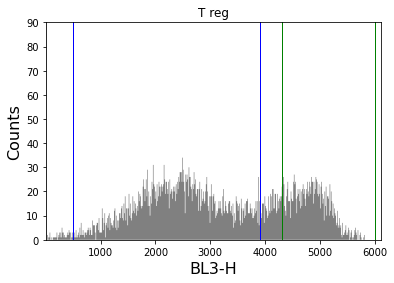

In [17]:
memtreggate = ThresholdGate(3900.0, ['BL3-H'], region='below') & ThresholdGate(500.0, ['BL3-H'], region='above')
naivetreggate = ThresholdGate(4300.0, ['BL3-H'], region='above') & ThresholdGate(6000.0, ['BL3-H'], region='below')
_ = sampletreg.plot(['BL3-H'],gates=[memtreggate,naivetreggate], bins=500)
plt.title("T reg")
plt.xlim(left=1)
plt.ylim(top=90)
print("Percent gated as Memory Treg: ", sampletreg.gate(memtreggate).counts/sampletreg.counts*100., "%")
print("Percent gated as Naive Treg: ", sampletreg.gate(naivetreggate).counts/sampletreg.counts*100., "%")

Shape of histogram differs from S3(C), so these gates based on percentages.

## D) NK Cells

Percent gated as NK:  7.8145614436073885 %
Percent gated as NKT:  2.7318830576632807 %


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


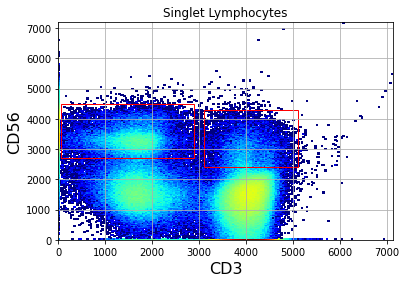

In [13]:
nk_gate = PolyGate([(0.05e3, 4.5e3), (2.9e3, 4.5e3), (2.9e3, 2.7e3), (0.05e3, 2.7e3)], ('VL4-H', 'BL3-H'), region='in', name='nk')
nkt_gate = PolyGate([(3.1e3, 2.4e3), (5.1e3, 2.4e3), (5.1e3, 4.3e3), (3.1e3, 4.3e3)], ('VL4-H', 'BL3-H'), region='in', name='nkt')
_ = panel2.plot(['VL4-H', 'BL3-H'], gates=[nk_gate,nkt_gate], gate_colors=['red','red'], cmap=cm.jet) #CD56 vs. CD3
samplenk = panel2.gate(nk_gate)
samplenkt = panel2.gate(nkt_gate)
print("Percent gated as NK: ", samplenk.counts/panel2.counts*100., "%")
print("Percent gated as NKT: ", samplenkt.counts/panel2.counts*100., "%")
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD56")
plt.grid()

Gated according to the projected shape of S3(D) without compensation. The percentage NK is slightly higher than 7%.

## E) CD8+ T cells

Percent gated as CD3+CD8+:  18.995172749160865 %


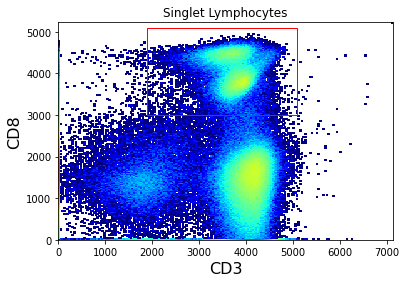

In [14]:
cd8_gate = PolyGate([(1.9e3, 3.0e3), (5.1e3, 3.0e3), (5.1e3, 5.1e3), (1.9e3, 5.1e3)], ('VL4-H', 'VL6-H'), region='in', name='cd8')
_ = panel3.plot(['VL4-H', 'VL6-H'], gates=cd8_gate, gate_colors=['red'], cmap=cm.jet) #CD8 vs. CD3
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD8")
print("Percent gated as CD3+CD8+: ", panel3.gate(cd8_gate).counts/panel3.counts*100., "%")

The shape and percentage are consistent with S3(E).

Percent gated as Cytotoxic Memory:  41.82224608814016 %
Percent gated as Cytotoxic Naive:  45.62483609525832 %


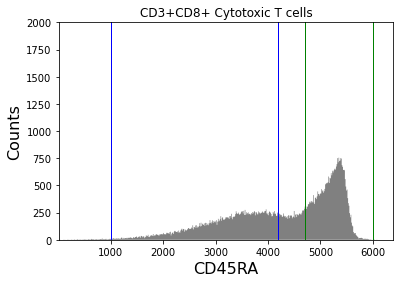

In [15]:
cd3cd8sample = panel3.gate(cd8_gate)
memcd3cd8gate = ThresholdGate(4200.0, ['BL3-H'], region='below') & ThresholdGate(1000.0, ['BL3-H'], region='above')
naivecd3cd8gate = ThresholdGate(4700.0, ['BL3-H'], region='above') & ThresholdGate(6000.0, ['BL3-H'], region='below')
_ = cd3cd8sample.plot(['BL3-H'], gates=[memcd3cd8gate,naivecd3cd8gate], bins=500)
plt.xlabel("CD45RA")
plt.title("CD3+CD8+ Cytotoxic T cells")
plt.xlim(left=1)
plt.ylim(top=2000)
print("Percent gated as Cytotoxic Memory: ", cd3cd8sample.gate(memcd3cd8gate).counts/cd3cd8sample.counts*100., "%")
print("Percent gated as Cytotoxic Naive: ", cd3cd8sample.gate(naivecd3cd8gate).counts/cd3cd8sample.counts*100., "%")

The shape is similar to S3(E), but the percentage of Cytotoxic Memory is slightly greater than the reference (39%).